In [1]:
# packages

%matplotlib inline

import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import statistics
import numpy as np
import scipy
from scipy import stats
import seaborn
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing dataset(Source : Kaggle (https://www.kaggle.com/pronto/cycle-share-dataset/))
data = pd.read_csv('trip.csv' , error_bad_lines=False) # cause offending lines to be skipped 

b'Skipping line 50794: expected 12 fields, saw 20\n'


# Exploratory Data Analysis

In [3]:
print(len(data))
data.head()

286857


,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0


##  Univariate Analysis

In [4]:
# determine time range of dataset
data = data.sort_values(by = 'starttime')
data.reset_index()
print('Data range of dataset: %s - %s'%(data.loc[1,'starttime'],data.loc[len(data)-1,'stoptime']))

Data range of dataset: 10/13/2014 10:32 - 9/1/2016 0:20


### Performing various Distribution studies in order to highlight the target audience

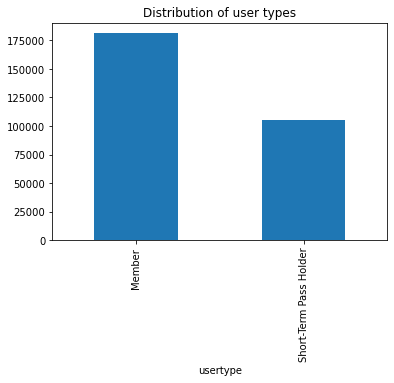

In [5]:
# distribution on the basis of usertype
groupby_user = data.groupby('usertype').size() # size of each group
groupby_user.plot.bar(title = 'Distribution of user types')

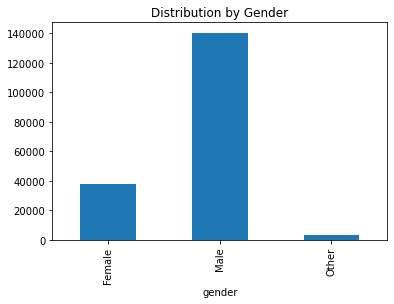

In [6]:
# distribution on the basis of gender
group_by_gender = data.groupby('gender').size()
group_by_gender.plot.bar(title = 'Distribution by Gender')

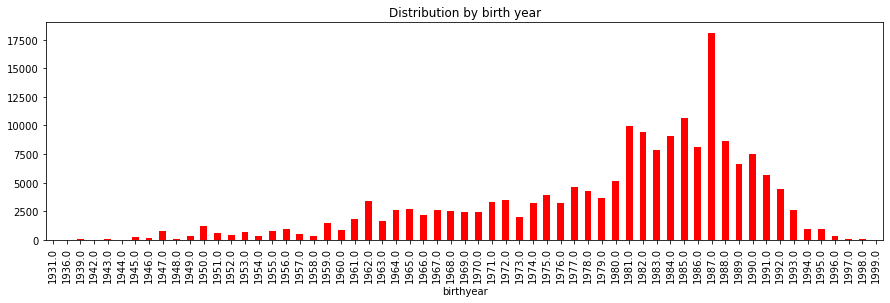

In [7]:
# distribution by birth year
data = data.sort_values(by = 'birthyear')
groupby_birthyear = data.groupby('birthyear').size()
groupby_birthyear.plot.bar(title = 'Distribution by birth year',color = 'red',figsize = (15,4))

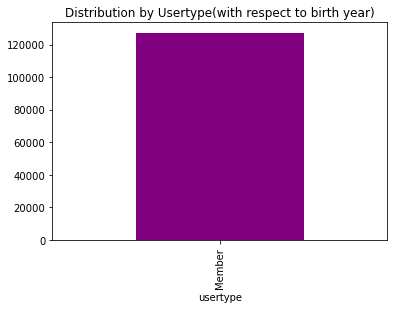

In [8]:
# distribution by usertypes for specific birth year
data_mil = data[(data['birthyear'] >= 1977) & (data['birthyear'] <= 1994)]
groupby_mil = data_mil.groupby('usertype').size()
groupby_mil.plot.bar(title = 'Distribution by Usertype(with respect to birth year)',color = 'purple')

## Multivariate Analysis

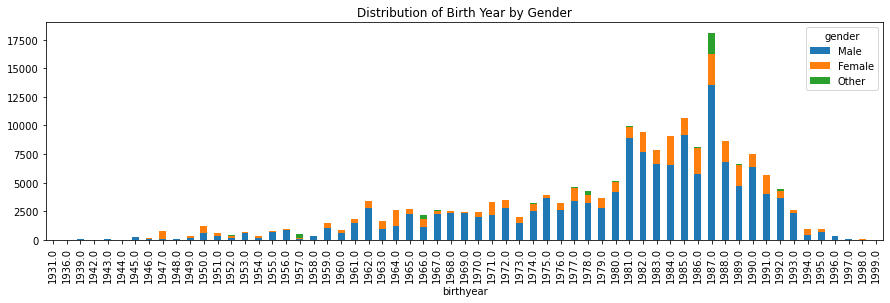

In [9]:
# plotting distribution of birth year by gender types
groupby_gender_birthyear = data.groupby(['birthyear','gender'])['birthyear'].count().unstack('gender').fillna(0)
groupby_gender_birthyear[['Male','Female','Other']].plot.bar(title = 'Distribution of Birth Year by Gender',stacked = True,figsize=(15,4))

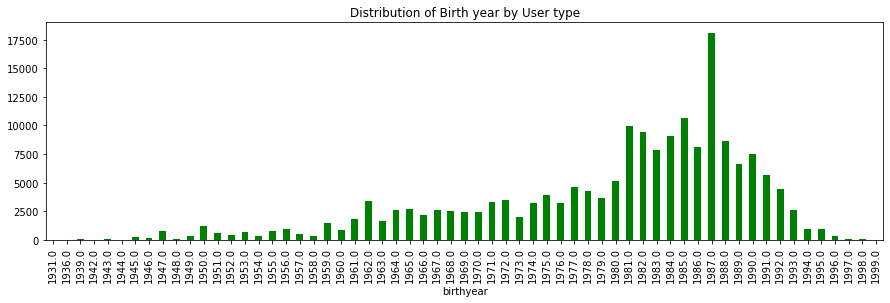

In [10]:
# distribution of birth year by usertype
groupby_birthyear_user = data.groupby(['birthyear','usertype'])['birthyear'].count().unstack('usertype').fillna(0)
groupby_birthyear_user['Member'].plot.bar(title = 'Distribution of Birth year by User type',stacked = True,figsize = (15,4),color='green')

In [11]:
# validation if we don't have birth year available for Short term pass holders
# data[data['usertype'] == 'Short-Term Pass Holder']['birthyear'].isnull().values.all()

In [12]:
# converting string to datetime and deriving new features
list_ = list(data['starttime'])
list_ = [datetime.datetime.strptime(x,"%m/%d/%Y %H:%M")for x in list_]
data['starttime_mod'] = pd.Series(list_,index = data.index)
data['starttime_date'] = pd.Series([x.date() for x in list_],index = data.index)
data['starttime_year'] = pd.Series([x.year for x in list_],index = data.index)
data['starttime_month'] = pd.Series([x.month for x in list_],index = data.index)
data['starttime_day'] = pd.Series([x.day for x in list_],index = data.index)
data['starttime_hour'] = pd.Series([x.hour for x in list_],index = data.index)

## Time Series Analysis

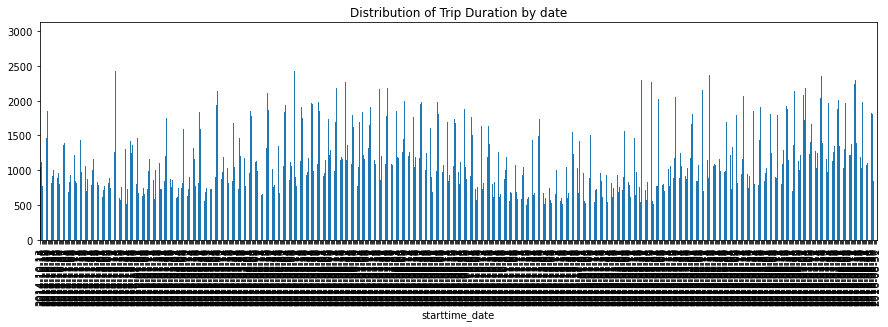

In [13]:
data.groupby('starttime_date')['tripduration'].mean().plot.bar(title = 'Distribution of Trip Duration by date',figsize = (15,4)) 

In [14]:
# Seasonality Distribution 

### Determining the measures of center using statistical packages
#### Performed in order to determine the frequently visited stations that thereby can be utilized effectively for promotional campaigns.

In [15]:
trip_duration = list(data['tripduration'])
station_from = list(data['from_station_name'])
# mean
print("Mean of trip duration %f"%statistics.mean(trip_duration))
# median
print("Median of trip duration %f"%statistics.median(trip_duration))
# mode : most trips originated from
print("Most trips originated from %s"%statistics.mode(station_from))

Mean of trip duration 1178.295675
Median of trip duration 624.842000
Most trips originated from Pier 69 / Alaskan Way & Clay St


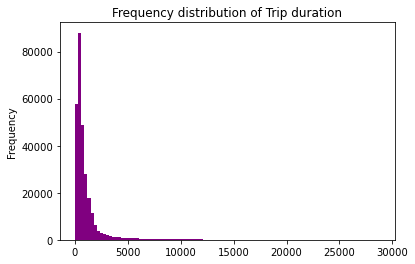

In [16]:
data['tripduration'].plot.hist(bins=100,title = 'Frequency distribution of Trip duration' , color = 'purple')
plt.show()

In [17]:
# the extremities are pulling the mean towards higher values keeping median with a pretty low value.

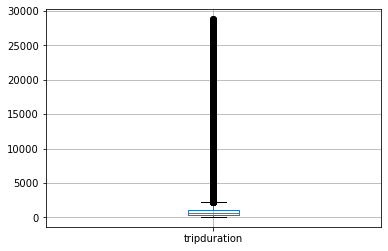

In [18]:
# To look for outliers
# Plotting box plot for the same.
box = data.boxplot(column = ['tripduration']) # column is an attribute
plt.show()

In [19]:
# determining ratio of values in observations of trip duration which are outliers 
q75 , q25 = np.percentile(trip_duration,[75,25])
iqr = q75-q25
print("Proportion of values as outliers : %f percent" %((len(data) - len([x for x in trip_duration if q75+(1.5*iqr)>=x>= q25-(1.5*iqr)]))*100/float(len(data))))

Proportion of values as outliers : 9.423859 percent


In [20]:
# as outlier value is very high that means the only option left is transformation
# calculating z scores for observations lying within trip_duration
mean_trip_duration = np.mean([x for x in trip_duration if q75+(1.5*iqr)>=x>= q25-(1.5*iqr)])
upper_whisker = q75+(1.5*iqr)
print("Mean of trip duration is %f"%mean_trip_duration)

Mean of trip duration is 700.594495


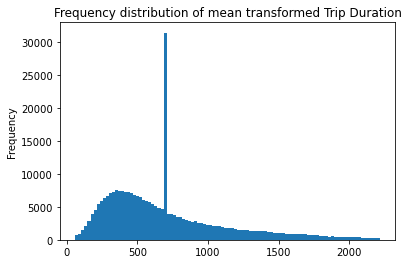

In [21]:
# transforming Dataset
def transform_trip_duration(x):
    if x > upper_whisker:
        return mean_trip_duration
    return x
data['tripduration_mean'] = data['tripduration'].apply(lambda x : transform_trip_duration(x))
data['tripduration_mean'].plot.hist(bins=100,title = 'Frequency distribution of mean transformed Trip Duration')
plt.show()

In [22]:
# determining measures of center without outliers
print("Mean of trip duration is %f"%data['tripduration_mean'].mean())
print("Standard Deviation of trip duration is %f"%data['tripduration_mean'].std())
print("Median of trip duration is %f"%data['tripduration_mean'].median())

Mean of trip duration is 700.594495
Standard Deviation of trip duration is 425.228763
Median of trip duration is 624.842000


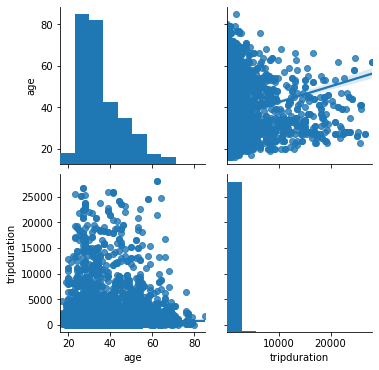

In [23]:
# pairplot AGE VS TRIPDURATION
data['age'] = data['starttime_year'] - data['birthyear']
data = data.dropna()
seaborn.pairplot(data,vars =['age','tripduration'],kind = 'reg')
plt.show()

In [24]:
# calculating correlation
pd.set_option('display.width',100)
pd.set_option('precision',3)
correlations = data[['tripduration','age']].corr(method='pearson')
print(correlations)

              tripduration    age
tripduration         1.000  0.056
age                  0.056  1.000


In [25]:
# computing two tail t-test of categories of gender 
for cat in ['gender']:
    
    print('Category: %s\n'%cat)
    groupby_category = data.groupby(['starttime_date', cat])['starttime_date'].count().unstack(cat)
    groupby_category = groupby_category.dropna()
    category_names = list(groupby_category.columns)
    print('Sub-category names : %s\n'%category_names)
                                                             
    for comb in [(category_names[i],category_names[j]) for i in range(len(category_names)) for j in range(i+1, len(category_names))]:
        print('%s %s'%(comb[0], comb[1]))
        t_statistics = stats.ttest_ind(list(groupby_category[comb[0]]),list(groupby_category[comb[1]]))
        print('Statistic :%f,P Value:%f'%(t_statistics.statistic, t_statistics.pvalue))
        print('\n')

Category: gender

Sub-category names : ['Female', 'Male', 'Other']

Female Male
Statistic :-33.551439,P Value:0.000000


Female Other
Statistic :42.197036,P Value:0.000000


Male Other
Statistic :46.259102,P Value:0.000000




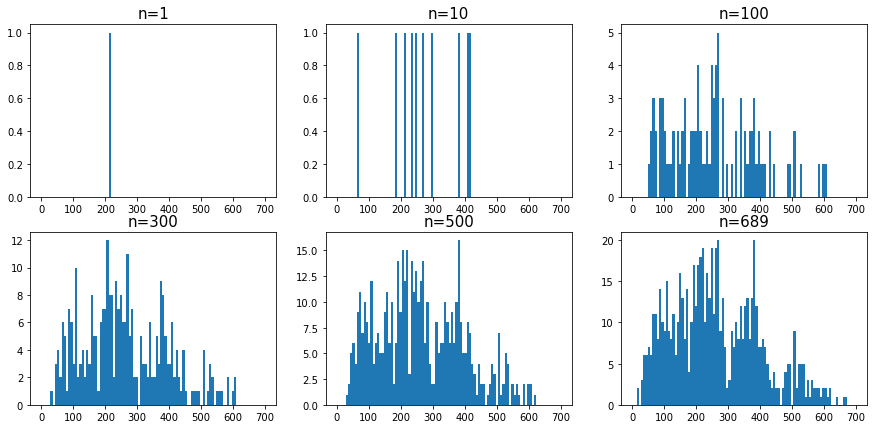

In [26]:
# script to validate the central limit theorem on trips dataset
daily_tickets = list(data.groupby('starttime_date').size())
sample_tickets = []
checkpoints = [1,10,100,300,500,1000]
plot_count = 1

random.shuffle(daily_tickets)

plt.figure(figsize=(15,7))
binrange=np.array(np.linspace(0,700,101))

for i in range(1000):
    if daily_tickets:
        sample_tickets.append(daily_tickets.pop())
        
    if i+1 in checkpoints or not daily_tickets:
        plt.subplot(2,3,plot_count)
        plt.hist(sample_tickets, binrange)
        plt.title('n=%d' % (i+1),fontsize=15) 
        plot_count+=1 
        
    if not daily_tickets:
        break
        
plt.show()

##### **CHALLENGE : Since the Short time pass customers dataset is very less and incomplete thereby more market research needs to be done in order to get significant insights regarding them.

### CASE FINDINGS:
####  -> Pier 69/Alaskan Way & Clay St. were the best station to kick off campaign promotions.
####  -> Most of the cusomers are males of a specific age group(1994-1997 born) are our target audience thereby promotional campaigns must be largely targeted for this group but yes simulatneously we must look for approaches or offers for other groups also just to increase their portion in ou customer count.
####  -> Outliers are tiny so we cannot remove them directly so these must be transformed.
####  -> Age and tripduration are also positively related (95% confidence level).
####  -> Central limit theorem was proved in order to define the significance of large dataset(atleast optimal such as not in the case of Short time pass customers.